In [123]:
from transformers import RobertaTokenizer, RobertaModel
import torch
import pandas as pd
import requests
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import random
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [102]:
def random_smiles_tanimoto(filtered_pairs):

    pfam_id = random.choice(filtered_pairs['pfam_id'].unique())
    smiles_list = filtered_pairs[filtered_pairs['pfam_id'] == pfam_id]['SMILES'].unique()

    s1, s2 = random.sample(list(smiles_list), 2)

    mol1 = Chem.MolFromSmiles(s1, sanitize=True)
    mol2 = Chem.MolFromSmiles(s2, sanitize=True)

    # Check if either molecule failed to parse
    if mol1 is None or mol2 is None:
        return "Invalid"

    morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)
    fp1 = morgan_gen.GetFingerprint(mol1)
    fp2 = morgan_gen.GetFingerprint(mol2)

    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [ ]:
data = pd.read_csv("~/Projects/ReverseLigQ_2/intsDB.csv", index_col = 0)
data

In [ ]:
smile_pfam_pairs = data[['SMILES', 'pfam_id']].dropna().drop_duplicates()
smile_pfam_pairs

In [ ]:
# Step 1: Count how many times each pfam_id appears (i.e. how many unique SMILES it has)
pfam_counts = smile_pfam_pairs['pfam_id'].value_counts()

# Step 2: Filter to pfam_ids that appear at least twice
pfam_with_multiple_smiles = pfam_counts[pfam_counts >= 2].index

# Step 3: Filter the unique_pairs dataframe
filtered_pairs = smile_pfam_pairs[smile_pfam_pairs['pfam_id'].isin(pfam_with_multiple_smiles)]

filtered_pairs

In [71]:
from rdkit.Chem import SanitizeMol, SANITIZE_PROPERTIES

In [ ]:
tanimoto_values = [random_smiles_tanimoto(filtered_pairs) for k in range(10000)]

In [95]:
tanimoto_values = [k for k in tanimoto_values if type(k)!=str]

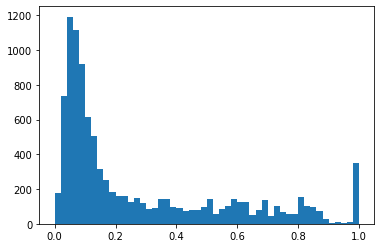

In [98]:
plt.hist(tanimoto_values, bins=50)
plt.show()

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = RobertaModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Make sure model is in evaluation mode
model.eval()

In [108]:
def random_embeddings_chemberta(model, filtered_pairs):
    
    pfam_id = random.choice(filtered_pairs['pfam_id'].unique())
    smiles_list = filtered_pairs[filtered_pairs['pfam_id'] == pfam_id]['SMILES'].unique()

    s1, s2 = random.sample(list(smiles_list), 2)
    inputs = tokenizer([s1, s2], return_tensors='pt', padding=True, truncation=True)
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        # Use CLS token embedding (first token) as representation
        embeddings = outputs.last_hidden_state[:, 0, :]
    embeddings = embeddings.numpy()
    
    return embeddings

In [109]:
embeddings = random_embeddings_chemberta(model, filtered_pairs)
embeddings

array([[ 0.3167928 , -1.1660854 , -1.0060098 , ..., -1.0414674 ,
         0.08669259,  1.2600448 ],
       [ 0.623222  , -0.0257732 ,  0.05027976, ..., -1.9774373 ,
        -0.74616134,  1.5629567 ]], dtype=float32)

In [124]:
def compare_multiple_embeddings(model, filtered_pairs, iterations=1000):
    cosine_distances, cosine_similarities = [], []
    for k in range(iterations):
        if k%100==0: print(k)
        embeddings = random_embeddings_chemberta(model, filtered_pairs)
        cosine_distances.append(cosine(embeddings[0], embeddings[1]))
        cosine_similarities.append(cosine_similarity([embeddings[0]], [embeddings[1]])[0][0])
    return cosine_distances, cosine_similarities

In [125]:
cosine_distances, cosine_similarities = compare_multiple_embeddings(model, filtered_pairs, iterations=1000)

0
100
200
300
400
500
600
700
800
900


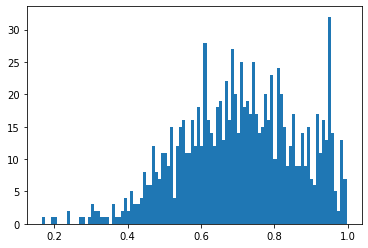

In [126]:
plt.hist(cosine_similarities, bins = 100)
plt.show()